In [23]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, thin
from skimage.io import imshow
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [2]:
def RGBtoYCbCr (R, G, B):
    R = int(R)
    G = int(G)
    B = int(B)
    R /= 255.0
    G /= 255.0
    B /= 255.0
    Y = 16 + (65.481 * R + 128.553 * G + 24.966 * B)
    Cb = 128 + (-37.797 * R - 74.203 * G + 112.0 * B)
    Cr = 128 + (112.0 * R - 93.786 * G - 18.214 * B)
    return Y, Cb, Cr

In [3]:
path = './Skin_NonSkin.txt'
content = ""
with open(path, 'r') as file:
    content = file.read()
entries = content.split('\n')
dataset = dict()
for line in entries:
    if line:
        R, G, B, label = line.split()
        label = int(label)
        if(label not in dataset):
            dataset[label] = []
        Y, Cb, Cr = RGBtoYCbCr(R, G, B)
        dataset[label].append([Cb, Cr])

In [4]:
def get_mean_cov(dataset):
    mean = dict()
    cov = dict()
    for label in dataset:
        data = np.array(dataset[label])
        mean[label] = np.mean(data, axis=0)
        cov[label] = np.cov(data, rowvar=False)
    return mean, cov
mean, cov = get_mean_cov(dataset)
skinMean = mean[1]
skinCov = cov[1]
nonSkinMean = mean[2]
nonSkinCov = cov[2]


In [5]:
def prob_c_label(C, mean, cov):

    C = np.array(C)
    mean = np.array(mean)
    cov = np.array(cov)

    C_diff = C - mean
    inv_cov = np.linalg.inv(cov)
    prob = np.exp(-0.5 * np.sum(C_diff @ inv_cov * C_diff, axis=-1))

    norm_factor = np.sqrt(np.linalg.det(cov) * (2 * np.pi) ** C.shape[1])
    
    return prob / norm_factor

def prob_skin_c(C, skinMean, skinCov, nonSkinMean, nonSkinCov):
    probCskin = prob_c_label(C, skinMean, skinCov)
    probCnonSkin = prob_c_label(C, nonSkinMean, nonSkinCov)

    return probCskin / (probCskin + probCnonSkin)

In [6]:
def cleanMask(skinMask):
    binaryMask = cv2.threshold(skinMask, 0.15, 1, cv2.THRESH_BINARY)[1]
    binaryMask = cv2.morphologyEx(binaryMask, cv2.MORPH_CLOSE, np.ones((3, 3)), iterations=2)
    binaryMask = cv2.morphologyEx(binaryMask, cv2.MORPH_OPEN, np.ones((3, 3)), iterations=2)
    return binaryMask
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

<>:1: SyntaxWarning: invalid escape sequence '\I'
<>:1: SyntaxWarning: invalid escape sequence '\I'
C:\Users\ASM EL Masrya\AppData\Local\Temp\ipykernel_31584\774499720.py:1: SyntaxWarning: invalid escape sequence '\I'
  image = cv2.imread('D:/3rd\IP\pro trial\img.jpg')


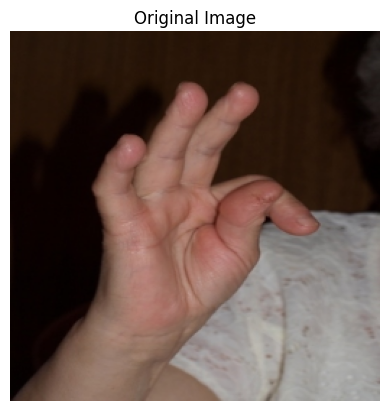

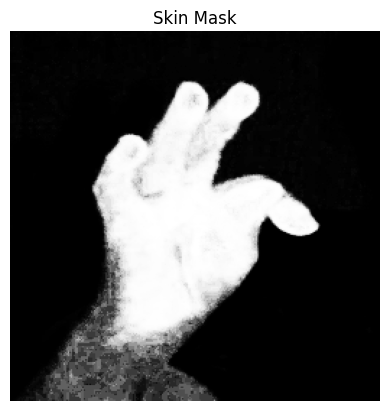

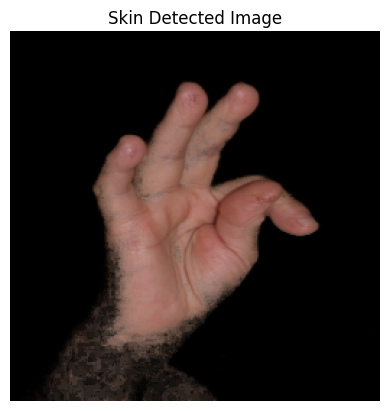

In [7]:
image = cv2.imread('D:/3rd\IP\pro trial\img.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256))
original = image.copy()
YCC = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
image = image.astype(np.float64) / 255
C = YCC[:, :, 1:]
skinMask = np.zeros((image.shape[0], image.shape[1]))
skinMask = prob_skin_c(C, skinMean, skinCov, nonSkinMean, nonSkinCov)


show_images([original], ['Original Image'])
show_images([skinMask], ['Skin Mask'])
show_images([image * skinMask[:, :, np.newaxis]], ['Skin Detected Image'])


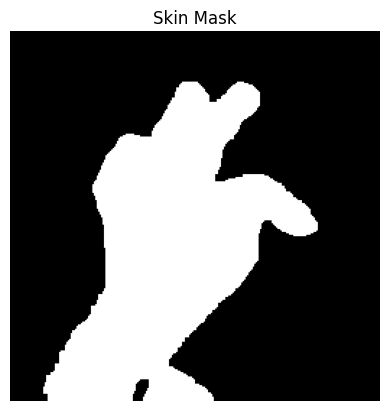

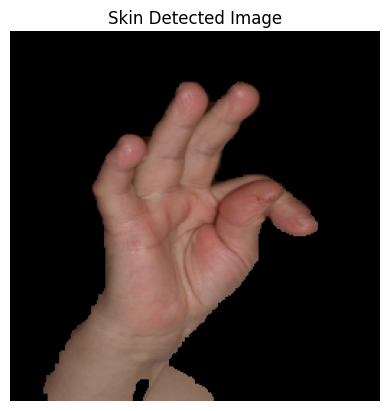

In [8]:
binaryMask = cleanMask(skinMask)
show_images([binaryMask], ['Skin Mask'])
show_images([image * binaryMask[:, :, np.newaxis]], ['Skin Detected Image'])

In [13]:
def getLiveFace(face_cascade):
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.imshow('Face Detection', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

In [14]:
def removeFaceMask(image, face_cascade):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    mask = np.ones((image.shape[0], image.shape[1]), dtype=np.uint8)
    
    Y, X = np.ogrid[:image.shape[0], :image.shape[1]]  # Create grid of indices
    for (x, y, w, h) in faces:
        center_x, center_y = x + w // 2, y + h // 2  
        radius = 1.1 * (max(w, h) // 2 ) 
        
        dist_from_center = (X - center_x)**2 + (Y - center_y)**2
        circular_mask = dist_from_center <= radius**2
        
        mask[circular_mask] = 0
    
    return mask
def getLiveMask(noFace = False): ### TODO MAKE IT FASTER
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        faceMask = np.ones((frame.shape[0], frame.shape[1]))
        if(noFace):
            faceMask = removeFaceMask(frame, face_cascade)
            frame = np.multiply(frame, faceMask[:, :, np.newaxis])
            frame = frame.astype(np.uint8)
        frame = cv2.resize(frame, (256, 256))
        cv2.imshow('Original Frame', frame)

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        print(faceMask)
        YCC = cv2.cvtColor(frame, cv2.COLOR_RGB2YCrCb)
        frame = frame.astype(np.float64) / 255
        C = YCC[:, :, 1:]
        skinMask = prob_skin_c(C, skinMean, skinCov, nonSkinMean, nonSkinCov)
        binaryMask = cleanMask(skinMask)
        frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        cv2.imshow('Skin Detection', frame * binaryMask[:, :, np.newaxis])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

In [15]:
getLiveMask(noFace=True)


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [

KeyboardInterrupt: 

In [28]:
def count_fingers(mask, debug=False):
    if mask.dtype == np.bool_:
        mask = mask.astype(np.uint8) * 255

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(largest_contour, returnPoints=False)
    defects = cv2.convexityDefects(largest_contour, hull)
    finger_count = 0
    for i in range(defects.shape[0]):
        start_idx, end_idx, far_idx, depth = defects[i, 0]
        start_point = tuple(largest_contour[start_idx][0])
        end_point = tuple(largest_contour[end_idx][0])
        far_point = tuple(largest_contour[far_idx][0])

        a = np.linalg.norm(np.array(start_point) - np.array(far_point))
        b = np.linalg.norm(np.array(end_point) - np.array(far_point))
        c = np.linalg.norm(np.array(start_point) - np.array(end_point))
        angle = np.arccos((a**2 + b**2 - c**2) / (2 * a * b))

        if angle < np.pi / 2 and depth > 10000: 
            finger_count += 1

            if debug:
                cv2.circle(mask, far_point, 5, (255, 0, 0), -1)
                cv2.line(mask, start_point, far_point, (0, 255, 0), 2)
                cv2.line(mask, end_point, far_point, (0, 255, 0), 2)

    return finger_count + 1

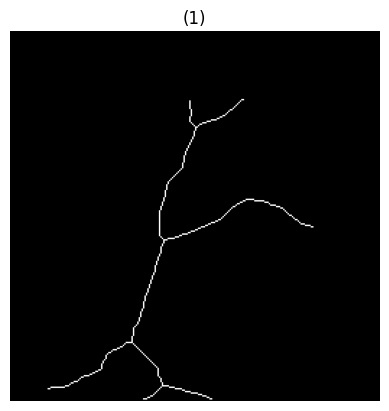

3


In [29]:
skeleton = skeletonize(binaryMask)
show_images([skeleton])
finger_count = count_fingers(skeleton)
print(finger_count)